8×8の升目にグレースケールの色がついています。

その色の組み合わせで0～9のどの数字を表しているか分類するAIを作成してみましょう。

今回使用するデータ「digits.csv」は、以下のような内容です。


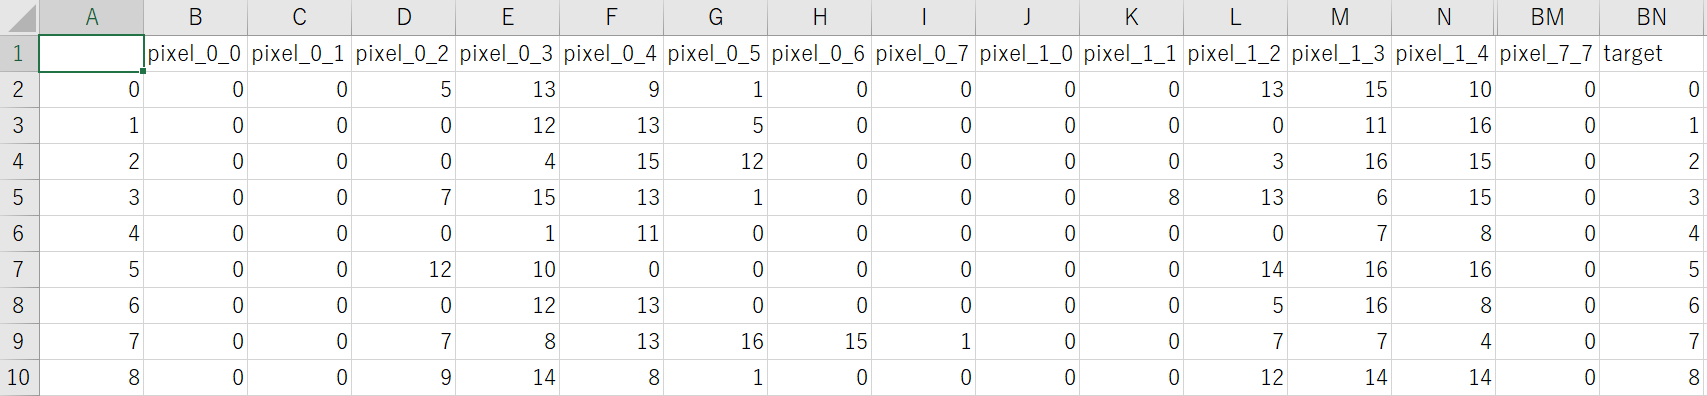

正解データ：Target

特徴量データ：pixel_0_0～pixel_7_7

※A列のデータはただの行番号の為、今回は使用しません

※それぞれの列の役割は下記を参照してください。

target 8×8の升が表現する数字
pixcel_0_0～pixel_7_7 各升目内のグレースケール

準備作業１．ドライブのマウント

In [ ]:
from google.colab import drive

準備作業１．ドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


準備作業２．ディレクトリの作成

In [2]:
mkdir data

準備作業３．ディレクトリへの移動

In [3]:
cd data

/content/data


準備作業４．今回使用するdigits.csvをアップロード
※コードなし

準備作業５．今回使用するライブラリのインストール



In [14]:
# pandsライブラリの使用
import pandas as pd

# モデルデータのインポート
# 今回は与えられたデータがどの値に該当するかの分類を行っていく為、モデルは決定木で行っていきます。
from sklearn import tree

# 訓練データ、検証データ、テストデータを分割する為に使用(後述)
from sklearn.model_selection import train_test_split

・CSVファイルの読み込みと表示

※データが正しく読み込まれているかを確認する為、必ずデータの表示を行いましょう。

In [7]:
# csvファイルの読み込み
df = pd.read_csv('digits.csv')

# データの確認(先頭5行・末尾5行)
print('-----先頭5行-----')
print(df.head(5))
print('-----末尾5行-----')
print(df.tail(5))

-----先頭5行-----
   Unnamed: 0  pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  \
0           0          0          0          5         13          9   
1           1          0          0          0         12         13   
2           2          0          0          0          4         15   
3           3          0          0          7         15         13   
4           4          0          0          0          1         11   

   pixel_0_5  pixel_0_6  pixel_0_7  pixel_1_0  ...  pixel_6_7  pixel_7_0  \
0          1          0          0          0  ...          0          0   
1          5          0          0          0  ...          0          0   
2         12          0          0          0  ...          0          0   
3          1          0          0          0  ...          0          0   
4          0          0          0          0  ...          0          0   

   pixel_7_1  pixel_7_2  pixel_7_3  pixel_7_4  pixel_7_5  pixel_7_6  \
0          0          6 

正解データの集計を行います。

正解データの数によって、この後のアプローチの仕方が変わってきます。

In [9]:
df['target'].value_counts()

3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: target, dtype: int64

　9つのデータが、大体同じくらいの数があるのが分かります。

　厳密に言えば「不均等データ」ですが、大雑把に言えば「均等データ」です。

　今回は学習の段階でそれぞれの違いを確認していくので、今はこのまま進めていきます。

【前処理】

機械学習を始めるための下準備として、前処理を行います。

データを学習させるために正しく整形しておくこのステップは、とても大切です。

前処理には、「ダミー変数化」、「欠損値の確認と処理」、「外れ値の確認と処理」があります。

ダミー変数化：質的データを学習に使えるように変換します。

※今回は質的データがないので省略します。

欠損値の処理：値が入っていないセルを、計算できるように仮の値で埋めます。

外れ値の処理：イレギュラーな値が入っていた場合、学習結果に影響を及ぼす事があるため、学習に使用されないように削除します。

※但し、決定木においては多少の外れ値では影響を受けない為、外れ値の処理自体を行わない事があります。

今回は、前処理として欠損値の確認だけ行いましょう。

In [10]:
# 欠損値の確認
df.isnull().sum()

Unnamed: 0    0
pixel_0_0     0
pixel_0_1     0
pixel_0_2     0
pixel_0_3     0
             ..
pixel_7_4     0
pixel_7_5     0
pixel_7_6     0
pixel_7_7     0
target        0
Length: 66, dtype: int64

　欠損値はありませんでしたので、このまま次の前処理に進みます。

特徴量と正解データの取り出し

　元のデータを、特徴量と正解データに分割します

　今回の元表を確認すると、「1行目は行番号の為使用しない」、「最後の行が正解データ」「それ以外の列が特徴量」となります。

In [19]:
# 特徴量として利用する列のリスト
x = df.loc[ : , 'pixel_0_0':'pixel_7_7']
t = df['target']

訓練データとテストデータの分割
　学習させるための訓練データと、モデルの動作を確認するテストデータに分割します。

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, t, test_size = 0.2, random_state = 0)
# x_trainのサイズを確認
x_train.shape

(1437, 64)

モデルの作成と学習

　決定木を使う為にDecisionTreeClassifierを使用します。

　前述の「厳密に言えば不均等データ」「大雑把に言えば均等データ」の確認をこの項目で行います。

　DecisionTreeClassifierの引数class_weightにbalancedを指定すると、比率の大きいデータの影響を小さくし、比率の小さいデータの影響度を大きくします。

　引数の有り無しで、モデルがどう変化するかを確認してみましょう。

In [32]:
# 均等データとして扱う
model = tree.DecisionTreeClassifier(max_depth = 5, random_state = 0)
model.fit(x_train, y_train) # 学習

# 不均等データとして扱う
model_bal = tree.DecisionTreeClassifier(max_depth = 5, random_state = 0, class_weight = 'balanced')
model_bal.fit(x_train, y_train) # 学習

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=0)

それぞれのモデルを評価してみましょう

In [33]:
# 均等データモデル
print(model.score(X = x_test, y = y_test))

# 不均等データ
print(model_bal.score(X = x_test, y = y_test))

0.7305555555555555
0.6611111111111111


　それぞれの結果をみると、今回のデータは「大雑把に均等データ」と見做す方が性能が上がりそうです。

　比較が済んだので、この後のチューニングは均等データモデルを使用して進めていきます。

In [34]:
# learn関数を定義して、チューニングの繰り返し作業を自動化する
def learn(x,t,depth=3):
    x_train,x_test,y_train,y_test = train_test_split(x,
        t,test_size = 0.2,random_state = 0)
    model = tree.DecisionTreeClassifier(max_depth =depth,random_state = 0,class_weight="balanced")
    model.fit(x_train,y_train)

    score=model.score(X=x_train,y=y_train)
    score2=model.score(X=x_test,y=y_test)
    return round(score,3),round(score2,3),model

　決定木の深さによる正解率の変化を確認する

In [35]:
for j in range(1,15): # jは木の深さ jには1～14が入る
    # xは特徴量、tは正解データ
    train_score,test_score,model = learn(x,t,depth = j)
    sentence="訓練データの正解率{}"
    sentence2="訓練データの正解率{}"
    total_sentence='深さ{}:'+sentence+sentence2
    print(total_sentence.format(j,
    train_score,test_score))

深さ1:訓練データの正解率0.2訓練データの正解率0.183
深さ2:訓練データの正解率0.317訓練データの正解率0.322
深さ3:訓練データの正解率0.484訓練データの正解率0.5
深さ4:訓練データの正解率0.59訓練データの正解率0.553
深さ5:訓練データの正解率0.706訓練データの正解率0.661
深さ6:訓練データの正解率0.824訓練データの正解率0.753
深さ7:訓練データの正解率0.892訓練データの正解率0.769
深さ8:訓練データの正解率0.929訓練データの正解率0.822
深さ9:訓練データの正解率0.956訓練データの正解率0.833
深さ10:訓練データの正解率0.979訓練データの正解率0.833
深さ11:訓練データの正解率0.99訓練データの正解率0.825
深さ12:訓練データの正解率0.996訓練データの正解率0.808
深さ13:訓練データの正解率0.999訓練データの正解率0.811
深さ14:訓練データの正解率0.999訓練データの正解率0.803


　訓練データでの予測性能が上がり、テストデータでの予測性能が低くなる事を過学習という。

In [37]:
# 今回は最も数値の高い深さ10でモデルを作成しておきましょう。
model = tree.DecisionTreeClassifier(max_depth = 10, random_state = 0)

# モデルの保存
import pickle
with open('ditits.csv', 'wb') as f:
  pickle.dump(model, f)

　ここまで決定木で行ってきましたが、他の分類方法も見てみましょう。

　基本的な部分はここまでの手順と同じ為、細かい解説は省略していきます。

【ロジスティック回帰】

　予測をするための計算式(回帰式)を作成するモデル。

In [39]:
# データの読み込み
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('digits.csv')
df.head(2)

,Unnamed: 0,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0,0,0,5,13,9,1,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,1,0,0,0,12,13,5,0,0,0,...,0,0,0,0,11,16,10,0,0,1


In [41]:
# 特徴量と正解データに分割
x = df.loc[ : , 'pixel_0_0':'pixel_7_7']
t = df['target']

# 特徴量の標準化(ロジスティック回帰は、特徴量の標準化が必要)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
new = sc.fit_transform(x)


In [42]:
# 訓練データと検証データに分割する
x_train, x_val, y_train, y_val = train_test_split(new, t, test_size = 0.2, random_state = 0)

In [45]:
# ロジスティック回帰による学習
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state = 0, C = 0.1, multi_class = 'auto', solver = 'lbfgs')

In [46]:
# 正解率の確認
model.fit(x_train, y_train)
print(model.score(x_train, y_train))
model.score(x_val, y_val)

0.988865692414753


0.9638888888888889

【ランダムフォレスト】

　決定木の上位互換！

In [49]:
df = pd.read_csv('digits.csv')

# ランダムフォレストのインポート
from sklearn.ensemble import RandomForestClassifier
x_train, x_test, y_train, y_test=train_test_split(x, t,
 test_size = 0.2, random_state = 0)
model = RandomForestClassifier(n_estimators = 200,
random_state = 0)

# モデルの学習
model.fit(x_train, y_train)

print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

1.0
0.9722222222222222


【アダブースト】

　モデルを逐次学習していき、次のモデルは、前のモデルの学習結果の情報利用して学習を進めるモデル。

In [50]:
# アダブーストのインポート
from sklearn.ensemble import AdaBoostClassifier

# ベースとなるモデル
from sklearn.tree import DecisionTreeClassifier

x_train, x_test, y_train, y_test = train_test_split(x, t,
test_size = 0.2, random_state = 0)
# 最大の深さ5の決定木を何個も作っていく
base_model = DecisionTreeClassifier(random_state = 0,
max_depth = 5)

# 決定木を500個作成
model = AdaBoostClassifier(n_estimators = 500,
random_state = 0, base_estimator = base_model)
model.fit(x_train,y_train) # 学習

print(model.score(x_train, y_train)) # 訓練データの正解率
print(model.score(x_test, y_test)) # テストデータの正解率


1.0
0.9638888888888889


　決定木の作成量が多いため、少し時間が掛かりました。

　このように、決定木にも様々な手法が用意されており、より確実な分類が出来よう、最適な物を模索していく必要があります。